## Quantitative trading in China A stock market with FinRL

### Import modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython import display
display.set_matplotlib_formats("svg")

from finrl_meta import config
from finrl_meta.data_processors.processor_tusharepro import TushareProProcessor, ReturnPlotter
from finrl_meta.env_stock_trading.env_stocktrading_A import StockTradingEnv
from drl_agents.stablebaselines3_models import DRLAgent
pd.options.display.max_columns = None
    
print("ALL Modules have been imported!")

ALL Modules have been imported!


### Create folders

In [2]:
import os
if not os.path.exists("./datasets" ):
    os.makedirs("./datasets" )
if not os.path.exists("./trained_models"):
    os.makedirs("./trained_models" )
if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log" )
if not os.path.exists("./results" ):
    os.makedirs("./results" )

### Download data, cleaning and feature engineering

In [3]:
ticket_list=['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH',
       '600031.SH', '600036.SH', '600050.SH', '600104.SH', '600196.SH',
       '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH']

train_start_date='2015-01-01'
train_stop_date='2019-08-01'
val_start_date='2019-08-01'
val_stop_date='2021-01-03'

token='27080ec403c0218f96f388bca1b1d85329d563c91a43672239619ef5'

In [4]:
# download and clean
ts_processor = TushareProProcessor("tusharepro", token=token)
df = ts_processor.download_data(ticket_list, train_start_date, val_stop_date, "1D")
df = ts_processor.clean_data(df)
df

100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Shape of DataFrame:  (21574, 8)
Please wait for a few seconds...
Shape of DataFrame:  (21930, 8)


,tic,date,open,high,low,close,volume,day
0,600000.SH,2015-01-05,15.88,16.25,15.56,16.07,5135687.09,0.0
1,600009.SH,2015-01-05,19.82,20.91,19.82,20.53,371485.54,0.0
2,600016.SH,2015-01-05,10.87,10.96,10.50,10.78,9138873.70,0.0
3,600028.SH,2015-01-05,6.59,7.14,6.45,7.14,11864996.45,0.0
4,600030.SH,2015-01-05,33.90,35.25,33.01,34.66,6986272.15,0.0
...,...,...,...,...,...,...,...,...
21925,600276.SH,2020-12-31,112.55,112.66,110.01,111.46,281568.85,3.0
21926,600309.SH,2020-12-31,89.88,91.48,88.70,91.04,213631.34,3.0
21927,600519.SH,2020-12-31,1941.00,1998.98,1939.00,1998.00,38860.07,3.0
21928,600547.SH,2020-12-31,23.60,23.75,23.48,23.62,213786.94,3.0


In [5]:
# add_technical_indicator
df = ts_processor.add_technical_indicator(df, config.TECHNICAL_INDICATORS_LIST)
df = ts_processor.clean_data(df)
df

Succesfully add technical indicators
Please wait for a few seconds...
Shape of DataFrame:  (21915, 15)


,tic,date,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,dx_30,close_30_sma,close_60_sma
0,600000.SH,2015-01-06,16.00,16.68,15.82,16.13,5116845.35,1.0,0.001346,16.184853,16.015147,100.000000,100.000000,16.100000,16.100000
1,600009.SH,2015-01-06,20.18,20.18,19.73,20.00,198117.45,3.0,-0.016008,20.663897,19.736103,12.828915,100.000000,20.200000,20.200000
2,600016.SH,2015-01-06,10.70,10.80,10.28,10.42,8965716.53,1.0,-0.008077,11.109117,10.090883,0.000000,100.000000,10.600000,10.600000
3,600028.SH,2015-01-06,7.18,7.22,6.81,7.00,10899984.33,1.0,-0.003141,7.267990,6.872010,0.000000,100.000000,7.070000,7.070000
4,600030.SH,2015-01-06,33.80,35.58,33.56,34.71,6681193.68,1.0,0.001122,34.755711,34.614289,100.000000,100.000000,34.685000,34.685000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21910,600276.SH,2020-12-31,112.55,112.66,110.01,111.46,281568.85,3.0,5.999563,120.049291,81.980709,65.497668,49.657169,96.356667,92.992167
21911,600309.SH,2020-12-31,89.88,91.48,88.70,91.04,213631.34,3.0,1.723646,92.780907,79.425093,58.501768,38.129756,85.693000,84.104667
21912,600519.SH,2020-12-31,1941.00,1998.98,1939.00,1998.00,38860.07,3.0,42.535547,1942.989267,1761.052733,66.422960,52.684229,1815.039333,1761.921500
21913,600547.SH,2020-12-31,23.60,23.75,23.48,23.62,213786.94,3.0,-0.252554,24.495355,23.032645,42.060734,0.003164,23.883667,24.534000


### Split traning dataset

In [6]:
train =ts_processor.data_split(df, train_start_date, train_stop_date)       
len(train.tic.unique())

15

In [7]:
train.tic.unique()

array(['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH',
       '600031.SH', '600036.SH', '600050.SH', '600104.SH', '600196.SH',
       '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH'],
      dtype=object)

In [8]:
train.head()

,tic,date,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,dx_30,close_30_sma,close_60_sma
0,600000.SH,2015-01-06,16.00,16.68,15.82,16.13,5116845.35,1.0,0.001346,16.184853,16.015147,100.000000,100.0,16.100,16.100
0,600009.SH,2015-01-06,20.18,20.18,19.73,20.00,198117.45,3.0,-0.016008,20.663897,19.736103,12.828915,100.0,20.200,20.200
0,600016.SH,2015-01-06,10.70,10.80,10.28,10.42,8965716.53,1.0,-0.008077,11.109117,10.090883,0.000000,100.0,10.600,10.600
0,600028.SH,2015-01-06,7.18,7.22,6.81,7.00,10899984.33,1.0,-0.003141,7.267990,6.872010,0.000000,100.0,7.070,7.070
0,600030.SH,2015-01-06,33.80,35.58,33.56,34.71,6681193.68,1.0,0.001122,34.755711,34.614289,100.000000,100.0,34.685,34.685


In [9]:
train.shape

(16725, 15)

In [10]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension*(len(config.TECHNICAL_INDICATORS_LIST)+2)+1
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 15, State Space: 136


### Train

In [35]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "print_verbosity": 1,
    "initial_buy":True,
    "hundred_each_trade":True
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [36]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [37]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
                "batch_size": 256, 
               "buffer_size": 50000, 
               "learning_rate": 0.0005,
               "action_noise":"normal",
                }
POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))
model_ddpg = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)

{'batch_size': 256, 'buffer_size': 50000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device


In [38]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                              tb_log_name='ddpg',
                              total_timesteps=10000)


Logging to tensorboard_log/ddpg/ddpg_40
Episode: 2
day: 1114, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1046404.36
total_reward: 46404.36
total_cost: 12057.02
total_trades: 16707
Sharpe: 0.203
Episode: 3
day: 1114, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 1034687.80
total_reward: 34687.80
total_cost: 94.20
total_trades: 16710
Sharpe: 0.401
Episode: 4
day: 1114, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 999920.13
total_reward: -79.87
total_cost: 79.87
total_trades: 16710
Sharpe: 0.332
Episode: 5
day: 1114, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 999920.13
total_reward: -79.87
total_cost: 79.87
total_trades: 16710
Sharpe: 0.384
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 83         |
|    time_elapsed    | 53         |
|    total timesteps | 4460       |
| train/             |            |
|    actor_loss      | 26.6       |
|    critic

### Trade

In [39]:
trade = ts_processor.data_split(df, val_start_date, val_stop_date)
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "print_verbosity": 1,
    "initial_buy":False,
    "hundred_each_trade":True
}
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [40]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                       environment = e_trade_gym)

Episode: 2
day: 345, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 2011336.31
total_reward: 1011336.31
total_cost: 68.69
total_trades: 3105
Sharpe: 2.025
hit end!


In [41]:
df_actions.to_csv("action.csv",index=False)
df_actions

,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600050.SH,600104.SH,600196.SH,600276.SH,600309.SH,600519.SH,600547.SH,600570.SH
date,,,,,,,,,,,,,,,
2019-08-01,0,0,0,0,0,0,0,0,100,100,900,0,900,0,1000
2019-08-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-08-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-08-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-08-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Backtest

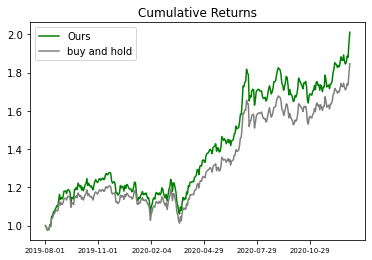

In [42]:
%matplotlib inline
plotter = ReturnPlotter(df_account_value, trade, val_start_date, val_stop_date)
plotter.plot()

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


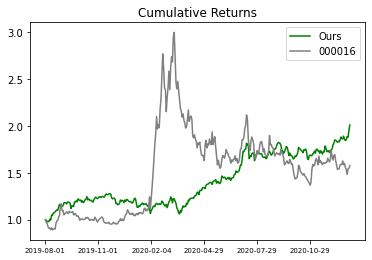

In [43]:
%matplotlib inline
# ticket: 上证50：000016    沪深300：399300
plotter.plot("000016")

#### Use pyfolio

In [44]:
baseline_df = plotter.get_baseline("000016")

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


In [45]:
import pyfolio
from pyfolio import timeseries
daily_return = plotter.get_return(df_account_value)
daily_return_base = plotter.get_return(baseline_df, value_col_name="close")

perf_func = timeseries.perf_stats
perf_stats_all = perf_func(returns=daily_return, 
                              factor_returns=daily_return_base, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.663547
Cumulative returns     1.011336
Annual volatility      0.270415
Sharpe ratio           2.024524
Calmar ratio           3.897694
Stability              0.834072
Max drawdown          -0.170241
Omega ratio            1.409850
Sortino ratio          3.107176
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.383428
Daily value at risk   -0.031897
Alpha                  0.626445
Beta                   0.122785
dtype: float64

Start date,2019-08-01
End date,2020-12-31
Total months,16
,Backtest
Annual return,66.355%
Cumulative returns,101.134%
Annual volatility,27.042%
Sharpe ratio,2.02
Calmar ratio,3.90
Stability,0.83
Max drawdown,-17.024%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.02,2019-11-20,2020-03-19,2020-04-17,108
1,10.34,2020-07-13,2020-07-24,2020-09-01,37
2,10.07,2020-09-01,2020-10-27,2020-12-08,71
3,5.79,2019-09-06,2019-09-11,2019-09-18,9
4,4.75,2019-10-15,2019-10-24,2019-11-08,19


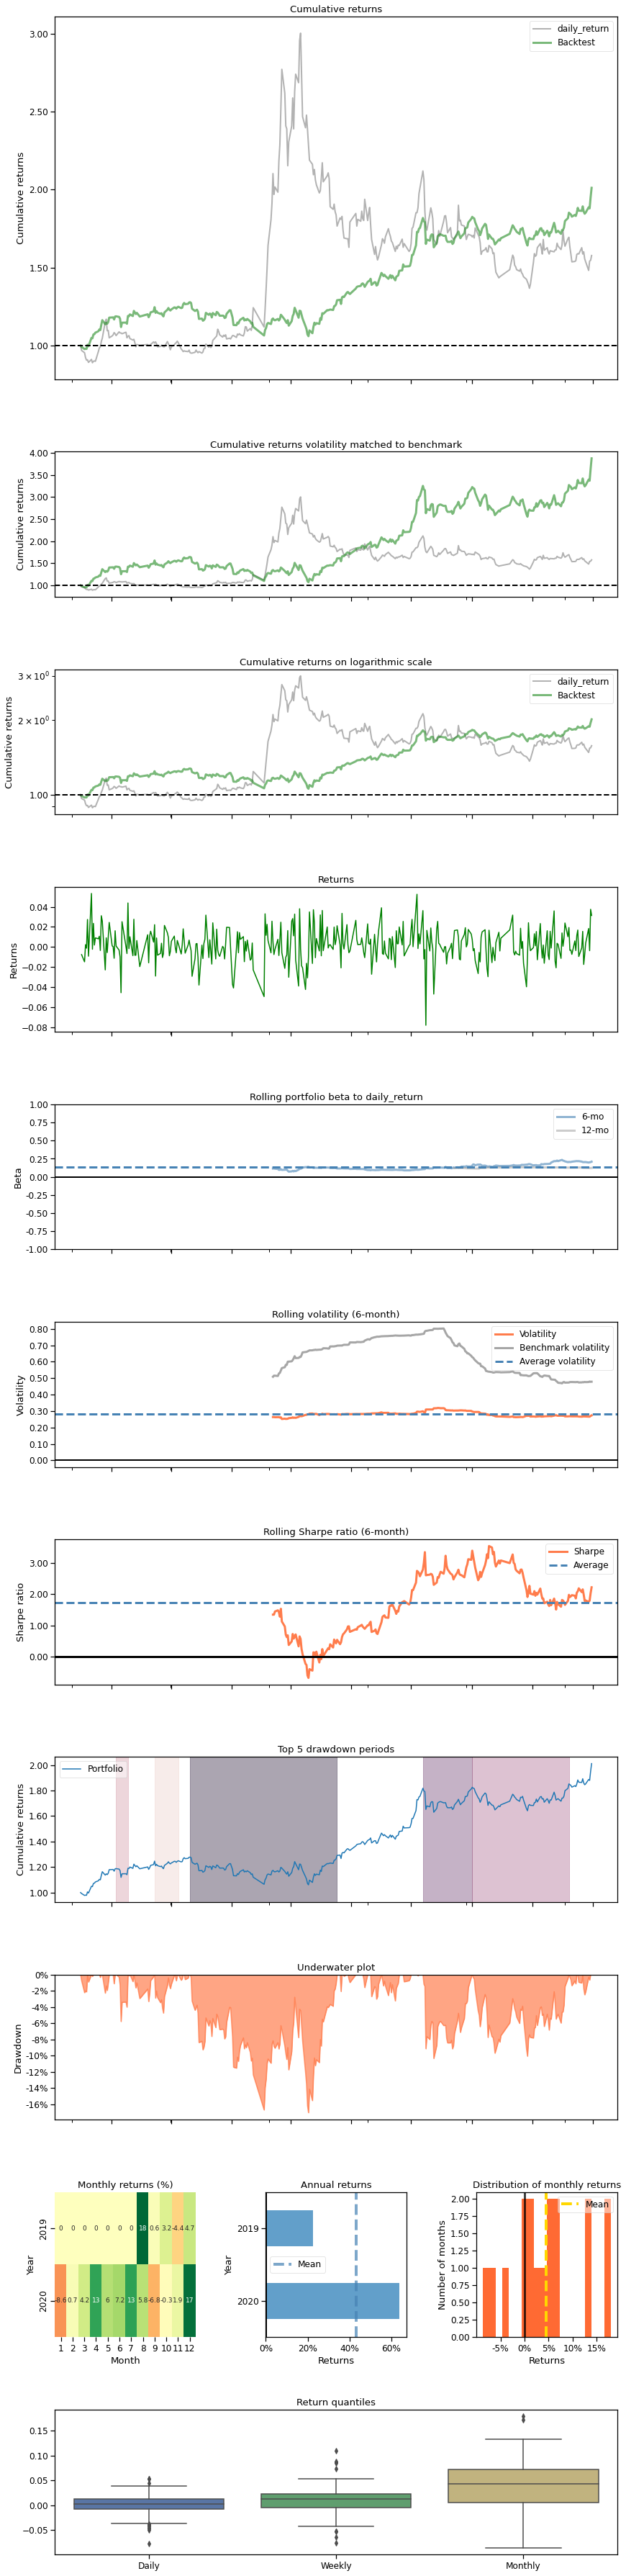

In [46]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = daily_return,
                                       benchmark_rets = daily_return_base, set_context=False)

### Authors
github username: oliverwang15, eitin-infant